# Hauptkomponentenanalyse (PCA)

In vielen Bereichen werden große Datensätze verwendet, welche ausgewertet oder veranschaulicht werden sollen. Hierfür ist häufig eine Dimensionsreduktion der Daten notwendig, wobei der Informationsverlust gleichtzeitig minimal zu halten ist.
Dieses zentrale Ziel wird durch die Hauptkomponentenanalyse (engl. principal component analysis, kurz PCA) erreicht.
Die Hauptkomponentenanalyse wird daher in vielen Anwendungsfeldern wie der Datenkompression, Merkmalsextraktion oder Datenvisualisierung verwendet $^{[1]}$.

Dieses Projekt erklärt die Hauptkomponentenanalyse am Beispiel eines Smileys. Hierfür ist ein interaktives Werkzeug entstanden, welches das Beispiel visualisiert. Im Folgenden werden die zentralen Konzepte der Hauptkomponentenanalyse anhand des Programmcodes erklärt.

Das Projekt ist in einem Jupyter Notebook umgesetzt, in dem sich textuelle Erklärungen und Programmcode-Abschnitte abwechseln. \
Die Bereitstellung des Notebooks erfolgt über Google colab. \
Um den Programmcode fehlerfrei auszuführen, muss jeder Codeabschnitt der Reihe nach durchlaufen werden. Hierfür klickt man am besten oben im Menü unter "Laufzeit" auf "Alle ausführen" (Ctrl + F9). Alternativ muss jeweils auf den "Ausführen-Knopf" auf der linken Seite zu Beginn jedes Programmcode-Abschnitts geklickt werden. \
War die Ausführung erfolgreich, wird am unteren Rand des Fensters die Dauer und Uhrzeit der abgeschlossenen Ausführung gemeinsam mit einem grünen Haken angezeigt. Nun können wir beginnen.

Zunächst benötigen wir einige Imports, die konzeptionell nicht weiter relevant sind.

In [23]:
#@title Imports

# Imports

import numpy as np

from ipywidgets import interact, interactive, fixed, interact_manual, FloatSlider, Label, HTML, Button, Layout
import ipywidgets as widgets

from IPython.display import display, clear_output, update_display
import IPython.display as display

from ipyevents import Event

import copy
import random

from PIL import Image, ImageDraw
import sklearn
from sklearn import decomposition

import os

$\textit{Hinweis:}$ In der grafischen Bildverarbeitung zeigt bei zweidimensionalen Koordinatensystemen die x-Achse nach rechts und die y-Achse nach unten - statt (wie in der Mathematik) nach oben. Dadurch liegt der Ursprung des Koordinatensystems in der linken oberen Ecke eines generierten Bildes mit üblicherweise ausschließlich positiven Werten.  

Ein Smiley wird hier vereinfacht durch $p = 9$ Punkte definiert. Da jeder zweidimensionale Punkt aus x- und y-Koordinate besteht, werden zur Beschreibung eines Smileys $d = 9 * 2 = 18$ Werte benötigt. Somit wird ein Smiley durch einen $18$-dimensionalen Vektor repräsentiert. \
Hierbei bezeichnen jeweils zwei aufeinanderfolgende Werte die x- und y-Koordinate eines Punktes. Die ersten beiden Punkte beschreiben die Augen des Smileys, die folgenden vier Punkte den Mund und die letzten beiden die Nase. Diese Reihenfolge zur Korrespondenz von Werten zu Punkten im Smiley muss für jeden Smiley beibehalten werden, damit sichergestellt ist, dass bei späteren Berechnungen Auge mit Auge, Nase mit Nase und Mund mit Mund verrechnet werden kann. \
Beispielsweise sieht der Vektor für einen glücklichen Smiley folgendermaßen aus:


In [24]:
happy = np.array([5.5, 1.75, 2.5, 1.75, 2, 5, 3, 5.75, 4, 6, 5, 5.75, 6, 5, 4, 3, 4, 4])

$$
\vec{v_{1}}= \left(\begin{array}{c} 5.5 \\ 1.75 \\ 2.5 \\ 1.75 \\ 2 \\ 5 \\ 3 \\ 5.75 \\ 4 \\ 6 \\ 5 \\ 5.75 \\ 6 \\ 5 \\ 4 \\ 3 \\ 4 \\ 4 \end{array}\right)
$$

$\textit{Hinweis:}$ Im Programmcode werden Zeilenvektoren statt Spaltenvektoren verwendet, wodurch diese und später verwendete Matrizen teilweise transponiert verwendet werden müssen. Daher kann sich die Implementierung der Formeln von den textuellen Erklärungen unterscheiden.

Diese Punkte aus $v_1$, die unseren glücklichen Smiley definieren, können wir nun auch zeichnen:

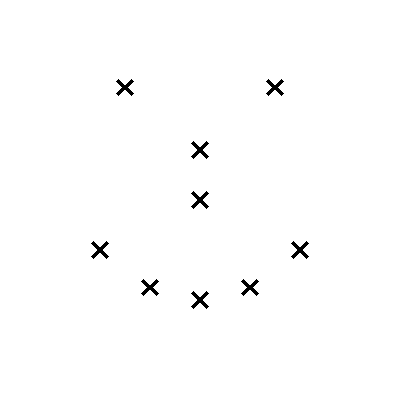

In [25]:
#@title Smiley punktweise zeichnen
# Ignore the code details

im = Image.new("RGB", (400, 400))
draw = ImageDraw.Draw(im)

def draw_smiley_pointwise(p: np.array, colorEyes, colorNose, colorMouth):

    p = copy.copy(p) * 50

    # Draw white background
    draw.rectangle([(0, 0), (400, 400)], "white")

    def draw_xmarks(draw, center, linelength=10, width=3, fill="black"):
        xyDiff = np.sqrt(2 * np.power(linelength/2, 2))
        coords = np.array([center[0]-xyDiff, center[1]-xyDiff, center[0]+xyDiff, center[1]+xyDiff, center[0]-xyDiff, center[1]+xyDiff, center[0]+xyDiff, center[1]-xyDiff])
        draw.line([(coords[0], coords[1]), (coords[2], coords[3])], fill=fill, width=width)
        draw.line([(coords[4], coords[5]), (coords[6], coords[7])], fill=fill, width=width)


    # Draw eyes
    right_eye_center, left_eye_center = p[0:2], p[2:4]
    draw_xmarks(draw, left_eye_center, fill=colorEyes)
    draw_xmarks(draw, right_eye_center, fill=colorEyes)

    # Draw nose
    nose_top, nose_bottom = p[14:16], p[16:18]
    draw_xmarks(draw, nose_top, fill=colorNose)
    draw_xmarks(draw, nose_bottom, fill=colorNose)

    # Draw mouth
    mouth = [p[4:6], p[6:8], p[8:10], p[10:12], p[12:14]]
    for x in mouth:
        draw_xmarks(draw, x, fill=colorMouth)

    display.display(im)


draw_smiley_pointwise(happy, "black", "black", "black")

Wenn wir die Augen, Nase und Mund jeweils verschieden einfärben, ist der Smiley schon besser erkennbar:

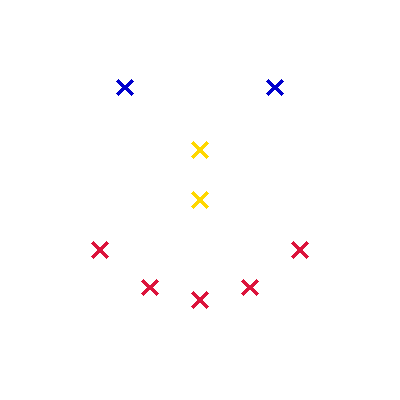

In [26]:
draw_smiley_pointwise(happy, "mediumblue", "gold", "crimson")

Die Punkte der Nase und des Munds können jetzt jeweils noch miteinander verbunden werden, um den Smiley zu vervollständigen. Außerdem werden zur Verschönerung beispielsweise die Augen als Kreise dargestellt. So wird aus einem Vektor ein Smiley. \
Die folgende Methode $\texttt{draw_smiley}$ zeichnet aus einem $18$-dimensionalen Vektor einen fertigen Smiley.

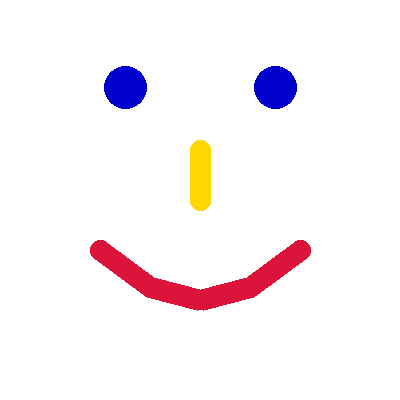

In [27]:
# Render Smiley

def draw_smiley(p: np.array):

    p = copy.copy(p) * 50

    # Draw white background
    draw.rectangle([(0, 0), (400, 400)], "white")

    # Draw eyes
    def draw_ellipse_around_point(draw, center, width=21, fill="black"):
        coords = np.concatenate((center - width, center + width), axis=-1)
        draw.ellipse([(coords[0], coords[1]), (coords[2], coords[3])], fill=fill)

    right_eye_center, left_eye_center = p[0:2], p[2:4]
    draw_ellipse_around_point(draw, left_eye_center, fill="mediumblue")
    draw_ellipse_around_point(draw, right_eye_center, fill="mediumblue")

    # Draw nose
    nose_top, nose_bottom = p[14:16], p[16:18]
    draw.line([tuple(nose_top), tuple(nose_bottom)], fill="gold", width=21)
    draw_ellipse_around_point(draw, nose_top, width=10, fill="gold")
    draw_ellipse_around_point(draw, nose_bottom, width=10, fill="gold")

    # Draw mouth
    mouth = [p[4:6], p[6:8], p[8:10], p[10:12], p[12:14]]
    mouth_tuple = [tuple(x) for x in mouth]
    draw.line(mouth_tuple, fill="crimson", width=21, joint="curve")
    draw_ellipse_around_point(draw, mouth[0], width=10, fill="crimson")
    draw_ellipse_around_point(draw, mouth[4], width=10, fill="crimson")

    display.display(im)


draw_smiley(happy)

Ein einzelner Smiley ($\hat{=}$ $d$-dimensionaler Vektor) bildet einen Datenpunkt für unsere Datenbasis. Die Datenbasis besteht aus $n$ Datenpunkten, wobei bei uns $n = 6$. \
Unsere Datenbasis besteht somit aus sechs verschiedenen Gesichtern, die (bis auf den bereits oben angelegten glücklichen Smiley) im nächsten Codeabschnitt definiert sind. Jeder Smiley-Vektor ist nach der gleichen oben beschriebenen Reihenfolge aufgebaut.

In [28]:
# Database

# happy = np.array([5.5, 1.75, 2.5, 1.75, 2, 5, 3, 5.75, 4, 6, 5, 5.75, 6, 5, 4, 3, 4, 4])
sad = np.array([5.5, 2, 2.5, 2, 2, 6, 3, 5.25, 4, 5, 5, 5.25, 6, 6, 4, 2.75, 4, 4])
drunken = np.array([5.75, 2.25, 2.25, 2.25, 2, 6, 3, 5, 4, 5.5, 5, 6, 6, 5, 4, 3, 4, 4.25])
LSD = np.array([6, 2.25, 2, 2.25, 2, 5, 3, 6, 4, 5.5, 5, 5, 6, 6, 4, 3.25, 4, 3.75])
neutral = np.array([5.5, 1.75, 2.5, 1.75, 2, 5, 3, 5.25, 4, 5.5, 5, 5.25, 6, 5, 4, 3, 4, 4])
crazy = np.array([5.5, 3.25, 2.5, 3.25, 2, 5, 3, 6.5, 4, 7, 5, 6.5, 6, 5, 4, 3.5, 4, 4.5])


# will be needed later:
horizontalCoord = (happy[5] + happy[9]) / 2
unenthusiasticIndividual = np.array([5.7, 1.25, 2.3, 1.25, 2, horizontalCoord, 3, horizontalCoord, 4, horizontalCoord, 5, horizontalCoord, 6, horizontalCoord, 4, 2.85, 4, 3.95])
unenthusiasticPoplulation = np.array([5.5, 1.75, 2.5, 1.75, 2, horizontalCoord, 3, horizontalCoord, 4, horizontalCoord, 5, horizontalCoord, 6, horizontalCoord, 4, 3, 4, 4])

smileIndividualVector = happy - unenthusiasticIndividual
smilePopulationVector = happy - unenthusiasticPoplulation

Aus diesen sechs Smileys besteht unsere Datenbasis:

In [29]:
#@title Datenbasisbilder laden
# Ignore the code

%%capture --no-display --no-stderr

# Load database images

if(os.path.exists('sample_data/Smiley2D') == False):
  !wget https://wwwcip.informatik.uni-erlangen.de/~qo50tabo/sample_data/Smiley2D.zip
  !unzip Smiley2D.zip -d sample_data

dataIm1 = open('sample_data/Smiley2D/out_happy.png','rb').read()
dataIm2 = open('sample_data/Smiley2D/out_sad.png','rb').read()
dataIm3 = open('sample_data/Smiley2D/out_drunken.png','rb').read()
dataIm4 = open('sample_data/Smiley2D/out_LSD.png','rb').read()
dataIm5 = open('sample_data/Smiley2D/out_neutral.png','rb').read()
dataIm6 = open('sample_data/Smiley2D/out_crazy.png','rb').read()
dataIm7 = open('sample_data/Smiley2D/out_unenthusiasticIndividual.png','rb').read()
dataIm8 = open('sample_data/Smiley2D/out_unenthusiasticPopulation.png','rb').read()


wiIm1 = widgets.Image(value=dataIm1, format='png', width=110, height=110)
wiIm2 = widgets.Image(value=dataIm2, format='png', width=110, height=110)
wiIm3 = widgets.Image(value=dataIm3, format='png', width=110, height=110)
wiIm4 = widgets.Image(value=dataIm4, format='png', width=110, height=110)
wiIm5 = widgets.Image(value=dataIm5, format='png', width=110, height=110)
wiIm6 = widgets.Image(value=dataIm6, format='png', width=110, height=110)
wiIm7 = widgets.Image(value=dataIm7, format='png', width=110, height=110)
wiIm8 = widgets.Image(value=dataIm8, format='png', width=110, height=110)

database_images = widgets.HBox([wiIm1, wiIm2, wiIm3, wiIm4, wiIm5, wiIm6])
display.display(database_images)

Die Datenmatrix $X$ ist eine $d\times n$ - Matrix, wobei die Vektoren der $n$ Datenpunkte die Spalten der Datenmatrix bilden:

$$
X =
\left( \begin{array}{cccccc}
\vdots & \vdots & \vdots & \vdots & \vdots & \vdots \\
v_{1} & v_{2} & v_{3} & v_{4} & v_{5} & v_{6} \\
\vdots & \vdots & \vdots & \vdots & \vdots & \vdots \\
\end{array}\right)
$$


In [30]:
X_T = np.array([happy, sad, drunken, LSD, neutral, crazy])

Die Hauptkomponentenanalyse wird (im Gegensatz zur verwandten Singulärwertzerlegung (SVD)$^{[1,2]}$) auf mittelwert-subtrahierten Daten durchgeführt. \
Hierfür wird der arithmetische Mittelwert $\mu$ der Datenpunkte $v_i$ folgendermaßen berechnet:

$$
\mu := \frac{1}{n} \sum_{i=1}^{n}{v_i}
$$
Im Programmcode wird der Mittelwert $\mu$ mit $\texttt{mean}$ bzw. als Zeilenvektor mit $\texttt{mean_T}$ bezeichnet.

In [31]:
mean_T = np.mean(X_T, axis=0)

Der mean-Vektor $\mu$ unserer Smiley-Datenbasis hat die folgenden Werte:

$$
\vec{\mu}= \left(\begin{array}{c} 5.625 \\ 2.20833333 \\ 2.375 \\ 2.20833333 \\ 2 \\ 5.33333333 \\ 3 \\ 5.625 \\ 4 \\ 5.75 \\ 5 \\ 5.625 \\ 6 \\ 5.33333333 \\ 4 \\ 3.08333333 \\ 4 \\ 4.08333333 \end{array}\right)
$$

Hierzu lässt sich auch der durch $\mu$ definierte Durchschnittssmiley visualisieren:

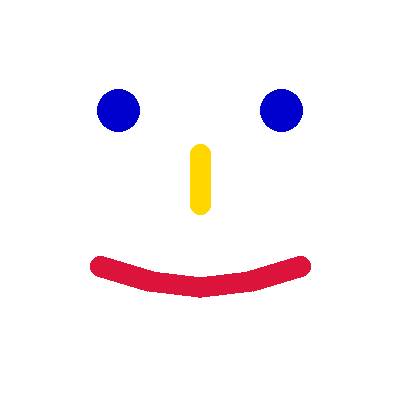

In [32]:
draw_smiley(mean_T)

Dieser Mittelwert muss nun von allen Datenpunkten $v_i$ subtrahiert werden, um normalisierte Kopien $v_i' := v_i - \mu$ zu erhalten.
Diese ergeben spaltenweise zusammengesetzt die normalisierte Datenmatrix $\tilde{X} \in \mathbb{R}^{d \times n}$:

$$
\tilde{X} =
\left( \begin{array}{cccccc}
\vdots & \vdots & \vdots & \vdots & \vdots & \vdots \\
v_{1}' & v_{2}' & v_{3}' & v_{4}' & v_{5}' & v_{6}' \\
\vdots & \vdots & \vdots & \vdots & \vdots & \vdots \\
\end{array}\right)
$$

Ziel ist es, bei der Hauptkomponentenanalyse eine Basis $\lbrace w_j \, | \, j = 1, \ldots, m \rbrace$ mit $m \leq d$ des Spanns der $v_i$ zu finden, die die Varianz maximiert. Da die punktweise Skalierung der $w_j$ auch die Varianz skaliert, stellen wir die zusätzliche Bedingung auf, dass
$$
\| w_j \|_2 = 1
\hspace{1cm}
$$
für alle $j$.

Hierfür definieren wir die Kovarianzmatrix $S \in \mathbb{R}^{d \times d}$:

$$
S := \frac{1}{n} \tilde{X} \tilde{X}^{T}
$$

Anschließend müssen die Eigenwerte $\lambda_i$ von $S$ und deren zugehörige Eigenvektoren $w_i$ berechnet werden.
Nun werden davon nur die $m$ Eigenvektoren $w_1, ..., w_m$ der größten Eigenwerte genommen $^{[1]}$. Diese $m$ sogenannten Hauptkomponenten bilden die gesuchte neue Basis.

$\textit{Hinweis:}$ Die Zahl $m$ kann beliebig gewählt werden. Da die Hauptkomponentenanalyse allerdings maximal $k-1$ aussagekräftige Eigenvektoren (d. h. Eigenvektoren zu Eigenwerten $\lambda_i \not = 0$) liefert, wobei $k := min(n, d)$, sollte $m \in \{ 1, ..., k-1\}$ sein $^{[3]}$. Je kleiner die Wahl von $m$, desto kleiner die Zieldimension, desto größer jedoch auch der Informationsverlust bei der Umwandlung der Daten vom ursprünglichen Datenraum in den sogenannten PCA-Raum. \
Der Wert eines Eigenwerts beschreibt die Varianz, die die zugehörige Hauptkomponente abbildet.

Die Hauptkomponentenanalyse wird im folgenden Programmcode durchgeführt, wobei in unserem Beispiel $m = 5$ (im Code $\texttt{M_COMPONENTS}$) gewählt wird. Die Eigenvektoren der gefundenen Basis werden in $\texttt{components}$ gespeichert.

In [33]:
# PCA

M_COMPONENTS = 5

PCA = sklearn.decomposition.PCA(n_components=M_COMPONENTS)
PCA.fit(X_T)
components = PCA.components_

stdDeviations = [np.sqrt(PCA.explained_variance_[0]), np.sqrt(PCA.explained_variance_[1]), np.sqrt(PCA.explained_variance_[2]),
                 np.sqrt(PCA.explained_variance_[3]), np.sqrt(PCA.explained_variance_[4])]


Nun haben wir die gewünschte Basis, bestehend aus den $m = 5$ normierten Basisvektoren $w_1, w_2, w_3, w_4$ und $w_5$:

$$
\vec{w_1} = \left(\begin{array}{c} -0.02761514 \\ 0.3934326 \\ 0.02761514 \\ 0.3934326 \\ 0. \\ -0.18074909 \\ 0. \\ 0.36466676 \\ 0. \\ 0.53884804 \\ 0. \\ 0.3728013 \\ 0. \\ 0.18888363 \\ 0. \\ 0.18286673 \\ 0. \\ 0.1574453 \end{array}\right) ,
\hspace{0.4cm}
\vec{w_2} = \left(\begin{array}{c} 0.15837053 \\ 0.05953233 \\ -0.15837053 \\ 0.05953233 \\ 0. \\ -0.42086492 \\ 0. \\ 0.47262055 \\ 0. \\ -0.01420654 \\ 0. \\ -0.4584762 \\ 0. \\ 0.51023183 \\ 0. \\ 0.1353312 \\ 0. \\ -0.23064818 \end{array}\right) ,
\hspace{0.4cm}
\vec{w_3} = \left(\begin{array}{c} -0.11039057 \\ -0.41100849 \\ 0.11039057 \\ -0.41100849 \\ 0. \\ -0.58895954 \\ 0. \\ 0.0654281 \\ 0. \\ 0.24256792 \\ 0. \\ -0.05694117 \\ 0. \\ -0.46659028 \\ 0. \\ 0.01232272 \\ 0. \\ -0.08171833 \end{array}\right) ,
\hspace{0.4cm}
\\
\vec{w_4} = \left(\begin{array}{c} -0.56129356 \\ -0.1103873 \\ 0.56129356 \\ -0.1103873 \\ 0. \\ 0.12942928 \\ 0. \\ 0.29329039 \\ 0. \\ 0.11717182 \\ 0. \\ 0.05174094 \\ 0. \\ 0.37097873 \\ 0. \\ -0.28716583 \\ 0. \\ 0.07912895 \end{array}\right) ,
\hspace{0.4cm}
\vec{w_5} = \left(\begin{array}{c} -0.30818905 \\ 0.33259592 \\ 0.30818905 \\ 0.33259592 \\ 0. \\ -0.30465606 \\ 0. \\ -0.36574707 \\ 0. \\ -0.18851046 \\ 0. \\ -0.49185763 \\ 0. \\ -0.17854551 \\ 0. \\ 0.09917843 \\ 0. \\ 0.20745535 \end{array}\right)
$$

Damit kann ein beliebiger Smiley durch einen $5$-dimensionalen Vektor $s$ (als Linearkombination der neuen Basisvektoren) statt eines $18$-dimensionalen Vektors angegeben werden.

Um aus dem $5$-dimensionalen Vektor $s$ aus unserem sog. PCA-Raum wieder einen  $18$-dimensionalen Vektor $s'$ aus unserem sog. Datenraum zu erhalten, den wir mit der $\texttt{draw_smiley}$-Methode als Smiley visualisieren können, wird eine Umwandlungsmatrix $W$ benötigt. Diese erhalten wir, wenn wir jeden Basisvektor $w_j$ mit seiner Standardabweichung, also der Wurzel aus seinem Eigenwert $\sqrt{\lambda_j}$, multiplizieren und die resultierenden Vektoren $\tilde{w_j}$ anschließend spaltenweise zu der Matrix $W$ zusammengesetzt werden. \
Für die Umwandlung von PCA-Raum zu Datenraum wird die neue Matrix $W$ mit dem $5$-dimensionalen Smiley-Vektor $s$ multipliziert und anschließend der Vektor des Durchschnittsgesichts $\mu$ addiert $^{[4]}$.

$$
s' = W \cdot s + \mu
\hspace{0.5cm}
,
\hspace{3.5cm}
\text{mit } \ W =
\left( \begin{array}{cccccc}
\vdots & \vdots & \vdots & \vdots & \vdots \\
\tilde{w_{1}} & \tilde{w_{2}} & \tilde{w_{3}} & \tilde{w_{4}} & \tilde{w_{5}} \\
\vdots & \vdots & \vdots & \vdots & \vdots \\
\end{array}\right)
,
\hspace{1.5cm}
\text{wobei } \ \tilde{w_j} := \sqrt{\lambda_j} \cdot \vec{w_j}
\hspace{1cm}
∀j \in \{1, ..., 5\}
$$


Dies setzt die Methode $\texttt{render_from_params}$ um und zeichnet den Smiley anschließend.

In [34]:
# From 5 to 18 dimensions

W_T = np.array([components[0] * stdDeviations[0], components[1] * stdDeviations[1], components[2] * stdDeviations[2],
                components[3] * stdDeviations[3], components[4] * stdDeviations[4]])

def render_from_params(v_T: np.array, sf1=0.00, sf2=0.00):

    p = copy.copy(mean_T)
    p += np.matmul(v_T, W_T)

    # will be needed later:
    p += sf1 * smileIndividualVector
    p += sf2 * smilePopulationVector

    draw_smiley(p)

Der Vektor
$$
\vec{s}= \left(\begin{array}{c} 0 \\ 0 \\ 0 \\ 0 \\ 0 \end{array}\right)
$$
stellt mit unserer neuen Basis demnach den Durchschnittssmiley dar.

Die Linearkombination mit beliebigen Parametern kann in unserem interaktiven Werkzeug auch ausgetestet werden. Dabei können mit den $5$ Schiebereglern die Parameter manuell verändert werden und mithilfe der soeben erklärten Berechnung wird davon abhängig der resultierende Smiley angezeigt. Hierbei kann man leicht feststellen, dass die erste Hauptkomponente ($\widehat{=}$ 1. Schieberegler) bei ihrer Modifikation am meisten Veränderung des Smileys bewirkt, also die größte Varianz abbildet, und diese von Hauptkomponente zu Hauptkomponente abnimmt. \
Mit dem "Random face"-Knopf kann ein zufälliger Vektor $s$ und somit ein zufälliger Smiley erzeugt werden. Die zufälligen Werte für den Vektor $s$ werden hierbei normalverteilt generiert. Mit Klicken auf den "Reset face"-Knopf werden alle Vektoreinträge von $s$ wieder auf $0$ gesetzt und somit der Durchschnittssmiley angezeigt. \
Diese Funktionen können hier auch ausprobiert werden. Wir starten beispielsweise mit dem Smiley zum Vektor
$$
\vec{s} = \left(\begin{array}{c} 0 \\ 0.5 \\ 1 \\ -0.2 \\ -0.5 \end{array}\right)
$$

In [35]:
#@title Helfer
# Ignore the code

# Important variables and methods

minSliderVal = -2
maxSliderVal = 2

a1 = widgets.FloatSlider(value=0.00, min=minSliderVal, max=maxSliderVal, step=0.05, continuous_update=False)
b1 = widgets.FloatSlider(value=0.50, min=minSliderVal, max=maxSliderVal, step=0.05, continuous_update=False)
c1 = widgets.FloatSlider(value=1.00, min=minSliderVal, max=maxSliderVal, step=0.05, continuous_update=False)
d1 = widgets.FloatSlider(value=-0.20, min=minSliderVal, max=maxSliderVal, step=0.05, continuous_update=False)
e1 = widgets.FloatSlider(value=-0.50, min=minSliderVal, max=maxSliderVal, step=0.05, continuous_update=False)

baseSliders1 = widgets.VBox([a1, b1, c1, d1, e1])

def getRandomSliderVals():
  return np.random.multivariate_normal(np.zeros(5), np.identity(5))

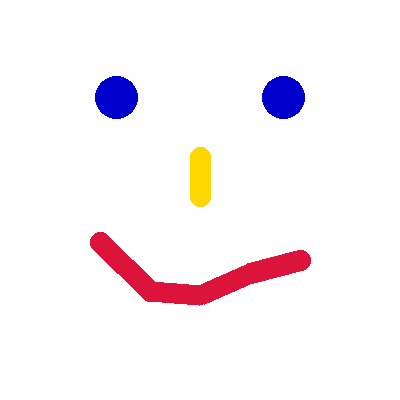

In [36]:
#@title Werkzeug Teil 1
# Ignore the code

# Tool part 1

# button definitions:
randomButton1 = widgets.Button(
    description='Random face',
    disabled=False,
    button_style='', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Random face',
)
resetButton1 = widgets.Button(
    description='Reset face',
    disabled=False,
    button_style='', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Reset face',
)

def randomFaceValues1():
  randomVals1 = getRandomSliderVals()
  changeAllBaseSliderValues1(randomVals1[0], randomVals1[1], randomVals1[2], randomVals1[3], randomVals1[4])

def resetFace1():
  changeAllBaseSliderValues1(0.00, 0.00, 0.00, 0.00, 0.00)

def changeAllBaseSliderValues1(v1, v2, v3, v4, v5):
  clear_output(wait=True)
  global a1, b1, c1, d1, e1
  a1 = widgets.FloatSlider(value=v1, min=minSliderVal, max=maxSliderVal, step=0.05, continuous_update=False)
  b1 = widgets.FloatSlider(value=v2, min=minSliderVal, max=maxSliderVal, step=0.05, continuous_update=False)
  c1 = widgets.FloatSlider(value=v3, min=minSliderVal, max=maxSliderVal, step=0.05, continuous_update=False)
  d1 = widgets.FloatSlider(value=v4, min=minSliderVal, max=maxSliderVal, step=0.05, continuous_update=False)
  e1 = widgets.FloatSlider(value=v5, min=minSliderVal, max=maxSliderVal, step=0.05, continuous_update=False)
  out1 = widgets.interactive_output(renderOutput1, {'a1': a1, 'b1': b1, 'c1': c1, 'd1': d1, 'e1': e1})
  baseSliders1 = widgets.VBox([a1, b1, c1, d1, e1])

  mainUi1 = widgets.HBox([out1, baseSliders1])
  ui1 = widgets.VBox([mainUi1, buttons1])
  display.display(ui1)

def renderOutput1(a1, b1, c1, d1, e1):
  v = np.array([a1, b1, c1, d1, e1])
  return render_from_params(v)

out1 = widgets.interactive_output(renderOutput1, {'a1': a1, 'b1': b1, 'c1': c1, 'd1': d1, 'e1': e1})

resetButton1.on_click(lambda _:resetFace1())
randomButton1.on_click(lambda _:randomFaceValues1())
buttons1 = widgets.HBox([randomButton1, resetButton1])
mainUi1 = widgets.HBox([out1, baseSliders1])
ui1 = widgets.VBox([mainUi1, buttons1])

display.display(ui1)


Andersherum ist die Umwandlung von Datenraum in PCA-Raum, also von der Darstellung in $18$ zu der in $5$ Dimensionen ebenso möglich. Haben wir einen gegebenen Smiley ($\hat{=}$ $18$-dimensionaler Vektor $s'$) und möchten die Linearkombination unserer neuen Basisvektoren erhalten, die dem gegebenen Smiley entspricht, so müssen wir das lineare Gleichungssystem
$$
W \cdot s = (s' - \mu)
$$
lösen. \

Dies ist durch die Matrixmultiplikation
$$
\tilde{s} = W^{-1} \cdot (s' - \mu)
$$
möglich. \
$\tilde{s}$ bezeichnet den resultierenden $5$-dimensionalen Vektor im PCA-Raum.

$\textit{Beachte: }$ Da $W$ nicht quadratisch ist, bezeichnet $W^{-1}$ die Pseudoinverse von $W$.

Für diese Berechnung ist die Methode $\texttt{getLinComb}$ zuständig:

In [37]:
# From 18 to 5 dimensions

def getLinComb(face: np.array):
  res_T = face - mean_T
  return np.matmul(res_T, np.linalg.pinv(W_T))

Somit können wir nun auch bereits bekannte Smileys aus dem Datenraum ($\hat{=} 18$-dimensionale Vektoren) in unserer neuen Basis beschreiben. Bereits bekannt sind uns zum Beispiel die Smileys der Datenbasis. Beim Klick auf den Knopf unter dem jeweiligen Bild eines dieser Smileys wird die soeben beschriebene Berechnung durchgeführt. Neben der Anzeige des richtigen Smileys werden dann auch die Parameter der $5$ Basisvektoren anhand der (hier deaktivierten) Schieberegler automatisch auf die zugehörigen Werte angepasst. \
Diese Funktion kann hier direkt ausprobiert werden:

In [38]:
#@title Helfer
# Ignore the code

# Important variables

a2 = widgets.FloatSlider(value=0.00, min=minSliderVal, max=maxSliderVal, step=0.05, disabled=True, continuous_update=False)
b2 = widgets.FloatSlider(value=0.00, min=minSliderVal, max=maxSliderVal, step=0.05, disabled=True, continuous_update=False)
c2 = widgets.FloatSlider(value=0.00, min=minSliderVal, max=maxSliderVal, step=0.05, disabled=True, continuous_update=False)
d2 = widgets.FloatSlider(value=0.00, min=minSliderVal, max=maxSliderVal, step=0.05, disabled=True, continuous_update=False)
e2 = widgets.FloatSlider(value=0.00, min=minSliderVal, max=maxSliderVal, step=0.05, disabled=True, continuous_update=False)

baseSliders2 = widgets.VBox([a2, b2, c2, d2, e2])

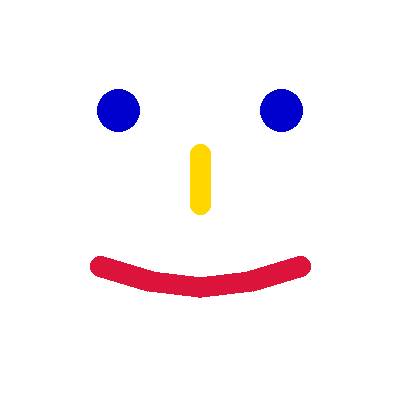

In [39]:
#@title Werkzeug Teil 2
# Ignore the code

# Tool part 2

# database images button definitions:
face1Button2 = widgets.Button(
    description='Face 1',
    disabled=False,
    button_style='', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Face 1',
    layout=Layout(width='70%'),
)
face2Button2 = widgets.Button(
    description='Face 2',
    disabled=False,
    button_style='', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Face 2',
    layout=Layout(width='70%'),
)
face3Button2 = widgets.Button(
    description='Face 3',
    disabled=False,
    button_style='', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Face 3',
    layout=Layout(width='70%'),
)
face4Button2 = widgets.Button(
    description='Face 4',
    disabled=False,
    button_style='', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Face 4',
    layout=Layout(width='70%'),
)
face5Button2 = widgets.Button(
    description='Face 5',
    disabled=False,
    button_style='', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Face 5',
    layout=Layout(width='70%'),
)
face6Button2 = widgets.Button(
    description='Face 6',
    disabled=False,
    button_style='', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Face 6',
    layout=Layout(width='70%'),
)


def changeAllBaseSliderValues2(v1, v2, v3, v4, v5):
  clear_output(wait=True)
  global a2, b2, c2, d2, e2
  a2 = widgets.FloatSlider(value=v1, min=minSliderVal, max=maxSliderVal, step=0.05, disabled=True, continuous_update=False)
  b2 = widgets.FloatSlider(value=v2, min=minSliderVal, max=maxSliderVal, step=0.05, disabled=True, continuous_update=False)
  c2 = widgets.FloatSlider(value=v3, min=minSliderVal, max=maxSliderVal, step=0.05, disabled=True, continuous_update=False)
  d2 = widgets.FloatSlider(value=v4, min=minSliderVal, max=maxSliderVal, step=0.05, disabled=True, continuous_update=False)
  e2 = widgets.FloatSlider(value=v5, min=minSliderVal, max=maxSliderVal, step=0.05, disabled=True, continuous_update=False)
  out2 = widgets.interactive_output(renderOutput2, {'a2': a2, 'b2': b2, 'c2': c2, 'd2': d2, 'e2': e2})
  baseSliders2 = widgets.VBox([a2, b2, c2, d2, e2])

  slidersAndStuff2 = widgets.VBox([baseSliders2, faces2])
  mainUi2 = widgets.HBox([out2, slidersAndStuff2])
  display.display(mainUi2)


def renderOutput2(a2, b2, c2, d2, e2):
  v = np.array([a2, b2, c2, d2, e2])
  return render_from_params(v)


out2 = widgets.interactive_output(renderOutput2, {'a2': a2, 'b2': b2, 'c2': c2, 'd2': d2, 'e2': e2})

def handle_ev1_2():
  linComb = getLinComb(happy)
  changeAllBaseSliderValues2(linComb[0], linComb[1], linComb[2], linComb[3], linComb[4])

def handle_ev2_2():
  linComb = getLinComb(sad)
  changeAllBaseSliderValues2(linComb[0], linComb[1], linComb[2], linComb[3], linComb[4])

def handle_ev3_2():
  linComb = getLinComb(drunken)
  changeAllBaseSliderValues2(linComb[0], linComb[1], linComb[2], linComb[3], linComb[4])

def handle_ev4_2():
  linComb = getLinComb(LSD)
  changeAllBaseSliderValues2(linComb[0], linComb[1], linComb[2], linComb[3], linComb[4])

def handle_ev5_2():
  linComb = getLinComb(neutral)
  changeAllBaseSliderValues2(linComb[0], linComb[1], linComb[2], linComb[3], linComb[4])

def handle_ev6_2():
  linComb = getLinComb(crazy)
  changeAllBaseSliderValues2(linComb[0], linComb[1], linComb[2], linComb[3], linComb[4])


face1_2 = widgets.VBox([wiIm1, face1Button2])
face2_2 = widgets.VBox([wiIm2, face2Button2])
face3_2 = widgets.VBox([wiIm3, face3Button2])
face4_2 = widgets.VBox([wiIm4, face4Button2])
face5_2 = widgets.VBox([wiIm5, face5Button2])
face6_2 = widgets.VBox([wiIm6, face6Button2])

face1_2.layout.align_items = 'center'
face2_2.layout.align_items = 'center'
face3_2.layout.align_items = 'center'
face4_2.layout.align_items = 'center'
face5_2.layout.align_items = 'center'
face6_2.layout.align_items = 'center'

faces2 = widgets.HBox([face1_2, face2_2, face3_2, face4_2, face5_2, face6_2])

face1Button2.on_click(lambda _:handle_ev1_2())
face2Button2.on_click(lambda _:handle_ev2_2())
face3Button2.on_click(lambda _:handle_ev3_2())
face4Button2.on_click(lambda _:handle_ev4_2())
face5Button2.on_click(lambda _:handle_ev5_2())
face6Button2.on_click(lambda _:handle_ev6_2())

slidersAndStuff2 = widgets.VBox([baseSliders2, faces2])
mainUi2 = widgets.HBox([out2, slidersAndStuff2])
display.display(mainUi2)


Wir können nicht nur beliebige Gesichter erzeugen, sondern auch bestehende Gesichter manipulieren. Als Beispiel dafür bietet sich ein Lächeln unseres Smileys an. \
Hierfür müssen wir zunächst einmal einen lächel-Vektor $l_1$ aus einem lächelnden und einem nicht-lächelnden Smiley berechnen, indem wir die Differenz der beiden nehmen. \
In unserem Beispiel nehmen wir die Differenz aus den folgenden beiden Smileys (bereits oben bei der Datenbasis als $\texttt{smileIndividualVector}$ berechnet):

In [40]:
# smileIndividualVector = happy - unenthusiasticIndividual

smileIndividualVector_images = widgets.HBox([wiIm1, wiIm7])
display.display(smileIndividualVector_images)

Die Modifikation mit diesem lächel-Vektor $l_1$ steht im interaktiven Werkzeug auch durch den "Smile $l_1$"-Schieberegler zur Verfügung. \
Wie man direkt sehen kann, verändert $l_1$ neben dem Mund auch die Position der Augen und ebenso die Position und Länge der Nase. Dies entsteht dadurch, dass wir bei der Berechnung des Lächel-Vektors $l_1$ zwei beliebige Smileys vergleichen, von denen einer lächelt und einer nicht. Dies entspricht jedoch nicht dem Unterschied von Lächeln und Nicht-Lächeln "desselben" Smileys. \
Betrachtet man die Smileys als "echte" (stilisierte) Gesichter, so würde man beim Lächeln "desselben" Smileys keine Positionsänderung der Augen und Nase, sondern nur eine Modifikation des Mundes erwarten. Zu diesem Ergebnis kommt man mit der Methode der Differenz von Smileys auch, wenn man alle lächelnden und nicht-lächelnden Smileys einer repräsentativen Datenmenge voneinander subtrahiert und aus den Ergebnissen den Durchschnitt bildet. \
Einen solchen "individualitätsbereinigten" lächel-Vektor $l_2$ bildet in dem interaktiven Werkzeug der "Smile $l_2$"-Schieberegler ab, bei dem nur der Mund modifiziert wird. Für diesen wurde bei uns vereinfacht die Differenz der folgenden beiden Smileys (berechnet als $\texttt{smilePopulationVector}$ oben nach der Datenbasis), die sich nur bezüglich des Mundes unterscheiden, genommen.

In [41]:
# smilePopulationVector = happy - unenthusiasticPoplulation

smilePopulationVector_images = widgets.HBox([wiIm1, wiIm8])
display.display(smilePopulationVector_images)

Diese Gesichtsmodifikation kann hier auch direkt getestet werden:

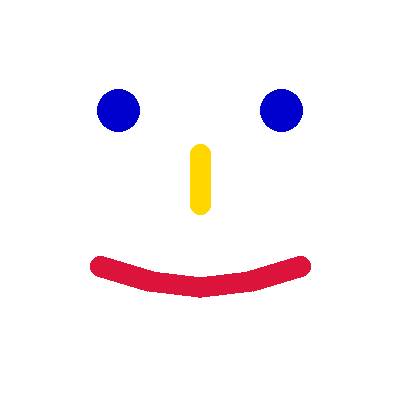

In [42]:
#@title Werkzeug Teil 3
# Ignore the code

# Tool part 3

smileIndividual3 = widgets.FloatSlider(value=0.00, min=-2.00, max=2.00, step=0.05, description='Smile l₁', orientation='vertical', continuous_update=False)
smilePopulation3 = widgets.FloatSlider(value=0.00, min=-2.00, max=2.00, step=0.05, description='Smile l₂', orientation='vertical', continuous_update=False)

def renderOutput3(sf1, sf2):
  v = np.zeros(5)
  return render_from_params(v, sf1, sf2)

out3 = widgets.interactive_output(renderOutput3, {'sf1': smileIndividual3, 'sf2': smilePopulation3})
slidersAligned3 = widgets.HBox([smileIndividual3, smilePopulation3])
mainUi3 = widgets.HBox([out3, slidersAligned3])

display.display(mainUi3)


Schließlich kommen wir zu dem interaktiven Werkzeug, bei dem man die Ergebnisse der Hauptkomponentenanalyse und unserer Berechnungen anhand des Smileys sehen kann. \
Standardmäßig zeigt das Bild den Durchschnittssmiley, mit den Schiebereglern und Knöpfen kann der Smiley nach Belieben modifiziert werden. Alle bisher vorgestellten Funktionen sind hier vereint und kombiniert testbar. Viel Spaß dabei!

Der noch folgende Programmcode ist nur für die Anzeige zuständig und konzeptionell irrelevant.

In [43]:
#@title Helfer
# Ignore the code

# Important variables and methods

a = widgets.FloatSlider(value=0.00, min=minSliderVal, max=maxSliderVal, step=0.05, continuous_update=False)
b = widgets.FloatSlider(value=0.00, min=minSliderVal, max=maxSliderVal, step=0.05, continuous_update=False)
c = widgets.FloatSlider(value=0.00, min=minSliderVal, max=maxSliderVal, step=0.05, continuous_update=False)
d = widgets.FloatSlider(value=0.00, min=minSliderVal, max=maxSliderVal, step=0.05, continuous_update=False)
e = widgets.FloatSlider(value=0.00, min=minSliderVal, max=maxSliderVal, step=0.05, continuous_update=False)
smileIndividual = widgets.FloatSlider(value=0.00, min=-2.00, max=2.00, step=0.05, description='Smile l₁', orientation='vertical', continuous_update=False)
smilePopulation = widgets.FloatSlider(value=0.00, min=-2.00, max=2.00, step=0.05, description='Smile l₂', orientation='vertical', continuous_update=False)

baseSliders = widgets.VBox([a, b, c, d, e])

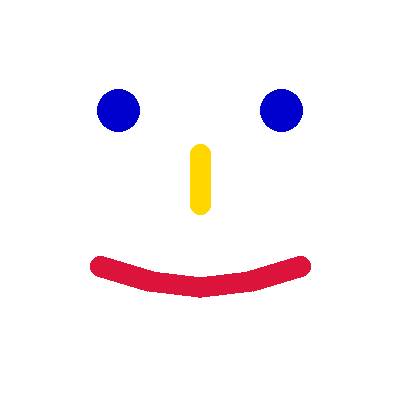

In [44]:
#@title Zentrales Werkzeug
# Ignore the code

# Main tool

randomButton = widgets.Button(
    description='Random face',
    disabled=False,
    button_style='', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Random face',
    # icon='check' # (FontAwesome names without the `fa-` prefix)
)

resetButton = widgets.Button(
    description='Reset face',
    disabled=False,
    button_style='', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Reset face',
    # icon='check' # (FontAwesome names without the `fa-` prefix)
)

# database images button definitions:
face1Button = widgets.Button(
    description='Face 1',
    disabled=False,
    button_style='', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Face 1',
    layout=Layout(width='70%'),
    # icon='check' # (FontAwesome names without the `fa-` prefix)
)
face2Button = widgets.Button(
    description='Face 2',
    disabled=False,
    button_style='', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Face 2',
    layout=Layout(width='70%'),
    # icon='check' # (FontAwesome names without the `fa-` prefix)
)
face3Button = widgets.Button(
    description='Face 3',
    disabled=False,
    button_style='', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Face 3',
    layout=Layout(width='70%'),
    # icon='check' # (FontAwesome names without the `fa-` prefix)
)
face4Button = widgets.Button(
    description='Face 4',
    disabled=False,
    button_style='', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Face 4',
    layout=Layout(width='70%'),
    # icon='check' # (FontAwesome names without the `fa-` prefix)
)
face5Button = widgets.Button(
    description='Face 5',
    disabled=False,
    button_style='', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Face 5',
    layout=Layout(width='70%'),
    # icon='check' # (FontAwesome names without the `fa-` prefix)
)
face6Button = widgets.Button(
    description='Face 6',
    disabled=False,
    button_style='', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Face 6',
    layout=Layout(width='70%'),
    # icon='check' # (FontAwesome names without the `fa-` prefix)
)


def randomFaceValues():
  randomVals = getRandomSliderVals()
  changeAllSliderValues(randomVals[0], randomVals[1], randomVals[2], randomVals[3], randomVals[4])

def resetFace():
  changeAllSliderValues(0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00)


def changeAllSliderValues(v1, v2, v3, v4, v5, sf1=5.00, sf2=5.00): # smileIndividual is set to sf1, if sf1!=5.00; smilePopulation is set to sf2, if sf2!=5.00
  clear_output(wait=True)
  global a, b, c, d, e, smileIndividual, smilePopulation
  a = widgets.FloatSlider(value=v1, min=minSliderVal, max=maxSliderVal, step=0.05, continuous_update=False)
  b = widgets.FloatSlider(value=v2, min=minSliderVal, max=maxSliderVal, step=0.05, continuous_update=False)
  c = widgets.FloatSlider(value=v3, min=minSliderVal, max=maxSliderVal, step=0.05, continuous_update=False)
  d = widgets.FloatSlider(value=v4, min=minSliderVal, max=maxSliderVal, step=0.05, continuous_update=False)
  e = widgets.FloatSlider(value=v5, min=minSliderVal, max=maxSliderVal, step=0.05, continuous_update=False)
  if(sf1 != 5.00):
    smileIndividual = widgets.FloatSlider(value=sf1, min=-2.00, max=2.00, step=0.05, description='Smile l₁', orientation='vertical', continuous_update=False)
  if(sf2 != 5.00):
    smilePopulation = widgets.FloatSlider(value=sf2, min=-2.00, max=2.00, step=0.05, description='Smile l₂', orientation='vertical', continuous_update=False)
  out = widgets.interactive_output(renderOutput, {'a': a, 'b': b, 'c': c, 'd': d, 'e': e, 'sf1': smileIndividual, 'sf2': smilePopulation})
  baseSliders = widgets.VBox([a, b, c, d, e])

  slidersAligned = widgets.HBox([baseSliders, smileIndividual, smilePopulation])
  slidersAndStuff = widgets.VBox([slidersAligned, faces])
  mainUi = widgets.HBox([out, slidersAndStuff])
  ui = widgets.VBox([mainUi, buttons])
  display.display(ui)


def renderOutput(a, b, c, d, e, sf1, sf2):
  v = np.array([a, b, c, d, e])
  return render_from_params(v, sf1, sf2)

out = widgets.interactive_output(renderOutput, {'a': a, 'b': b, 'c': c, 'd': d, 'e': e, 'sf1': smileIndividual, 'sf2': smilePopulation})


def handle_ev1():
  linComb = getLinComb(happy)
  changeAllSliderValues(linComb[0], linComb[1], linComb[2], linComb[3], linComb[4], 0.00, 0.00)

def handle_ev2():
  linComb = getLinComb(sad)
  changeAllSliderValues(linComb[0], linComb[1], linComb[2], linComb[3], linComb[4], 0.00, 0.00)

def handle_ev3():
  linComb = getLinComb(drunken)
  changeAllSliderValues(linComb[0], linComb[1], linComb[2], linComb[3], linComb[4], 0.00, 0.00)

def handle_ev4():
  linComb = getLinComb(LSD)
  changeAllSliderValues(linComb[0], linComb[1], linComb[2], linComb[3], linComb[4], 0.00, 0.00)

def handle_ev5():
  linComb = getLinComb(neutral)
  changeAllSliderValues(linComb[0], linComb[1], linComb[2], linComb[3], linComb[4], 0.00, 0.00)

def handle_ev6():
  linComb = getLinComb(crazy)
  changeAllSliderValues(linComb[0], linComb[1], linComb[2], linComb[3], linComb[4], 0.00, 0.00)


face1 = widgets.VBox([wiIm1, face1Button])
face2 = widgets.VBox([wiIm2, face2Button])
face3 = widgets.VBox([wiIm3, face3Button])
face4 = widgets.VBox([wiIm4, face4Button])
face5 = widgets.VBox([wiIm5, face5Button])
face6 = widgets.VBox([wiIm6, face6Button])

face1.layout.align_items = 'center'
face2.layout.align_items = 'center'
face3.layout.align_items = 'center'
face4.layout.align_items = 'center'
face5.layout.align_items = 'center'
face6.layout.align_items = 'center'

faces = widgets.HBox([face1, face2, face3, face4, face5, face6])

resetButton.on_click(lambda _:resetFace())
randomButton.on_click(lambda _:randomFaceValues())
face1Button.on_click(lambda _:handle_ev1())
face2Button.on_click(lambda _:handle_ev2())
face3Button.on_click(lambda _:handle_ev3())
face4Button.on_click(lambda _:handle_ev4())
face5Button.on_click(lambda _:handle_ev5())
face6Button.on_click(lambda _:handle_ev6())

buttons = widgets.HBox([randomButton, resetButton])

slidersAligned = widgets.HBox([baseSliders, smileIndividual, smilePopulation])
slidersAndStuff = widgets.VBox([slidersAligned, faces])
mainUi = widgets.HBox([out, slidersAndStuff])
ui = widgets.VBox([mainUi, buttons])

display.display(ui)


Wie ein solches Beispiel für die Hauptkomponentenanalyse auf mehr Dimensionen und komplexere Anwendungen übertragen werden kann, wird in dem folgenden Notebook zur PCA auf Gesichtern in 3D dargelegt:
https://colab.research.google.com/drive/1f2wIMxudZXfhUZxraRuHytSVpzSmRq3p?usp=sharing

### Quellen:

$[1]$ Takio Kurita. “Principal Component Analysis (PCA)”. In: Computer Vision. Springer eBook Collection. Cham: Springer International Publishing und Springer, 2019, S. 1–4. ISBN: 978-3-030-03243-2. DOI: 10.1007/978-3-030-03243-2_649-1. \
$[2]$ Kaare Brandt Petersen und Michael Syskind Pedersen. “The Matrix Cookbook”. In: Technical University of Denmark 7.15 (2012). URL: https://www.math.uwaterloo.ca/~hwolkowi/matrixcookbook.pdf. \
$[3]$ M. Turk und A. Pentland. “Eigenfaces for recognition”. In: Journal of cognitive neuroscience 3.1 (1991), S. 71–86. ISSN: 0898-929X. DOI: 10.1162/jocn.1991.3.1.71. \
$[4]$ Thomas Albrecht et al. “Posterior shape models”. In: Medical Image Analysis 17.8 (2013), S. 959–973. ISSN: 1361-8415. DOI: 10.1016/j.media.2013.05.010. URL: https://www.sciencedirect.com/science/article/pii/S1361841513000844.

